# General Linear Model for roadtypes features 


## import environment and load data

### environment setup

In [7]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 

import pandas as pd
import numpy as np
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
import PIL.Image
from scipy.io import savemat, loadmat
from sklearn.decomposition import PCA, IncrementalPCA
# from skimage import io, transform

import nibabel as nib
import nilearn as nil
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
import glob
from nilearn.image import concat_imgs, index_img

import matplotlib.pyplot as plt
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn

import glob
import pickle
from time import sleep
from datetime import datetime
from einops import rearrange

%autosave 5
%matplotlib inline
# %matplotlib widget

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/spatial_process"
fMRI_data_dir="/media/statespace/Spatial/sptialworkspace/spatialnavigation/fMRI_data/spatialfMRI_nii"

preprocessed_dir=project_dir+"/preprocess/preprocessed/afni_2021"
processed_dir=project_dir+"/process/processed"

# important variables
num_TRs_video = 200
start_fixation_TRs = 3
hemodynamic_shift_TRs = 3
num_runs = 14
num_TRs = 223
num_road_types = 4
num_total_dims = 1409

# debug
glm_show_alpha = False

# shuffle times
shuffle_num_times = 100


Autosaving every 5 seconds


### data preparation

##### load design matrix

In [8]:
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/spatial_process"
processed_dir=project_dir+"/process/processed/autoencoder"
file_dir = os.path.join(processed_dir, "design_matrix")

matdic = loadmat(os.path.join(file_dir, "design_matrix_alltowns_roadtypes_5.mat"))

design_matrix_alltowns = matdic["design_matrix_alltowns"]
print("design matrix for all towns (n_TRs, n_road_types) =", design_matrix_alltowns.shape)

if(np.isnan(design_matrix_alltowns).any()):
    print("design_matrix_alltowns contain NaN values")
    
## may not add zscore
# design_matrix_alltowns = stats.zscore(design_matrix_alltowns, axis=0)

if(np.isnan(design_matrix_alltowns).any()):
    print("design_matrix_alltowns contain NaN values")

design matrix for all towns (n_TRs, n_road_types) = (1784, 15)


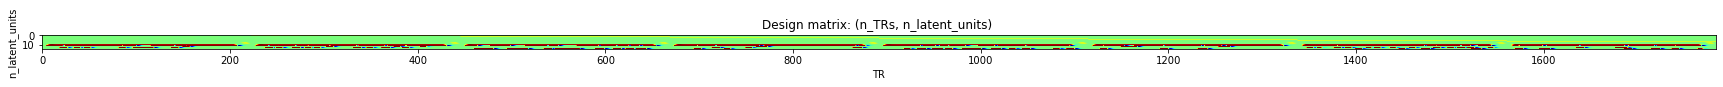

In [9]:
plt.figure(figsize=(30, 20))
plt.title('Design matrix: (n_TRs, n_latent_units) ')
plt.xlabel('TR')
plt.ylabel('n_latent_units')
plt.imshow(design_matrix_alltowns.T, cmap='jet', vmin=-5, vmax=5)
# plt.colorbar()

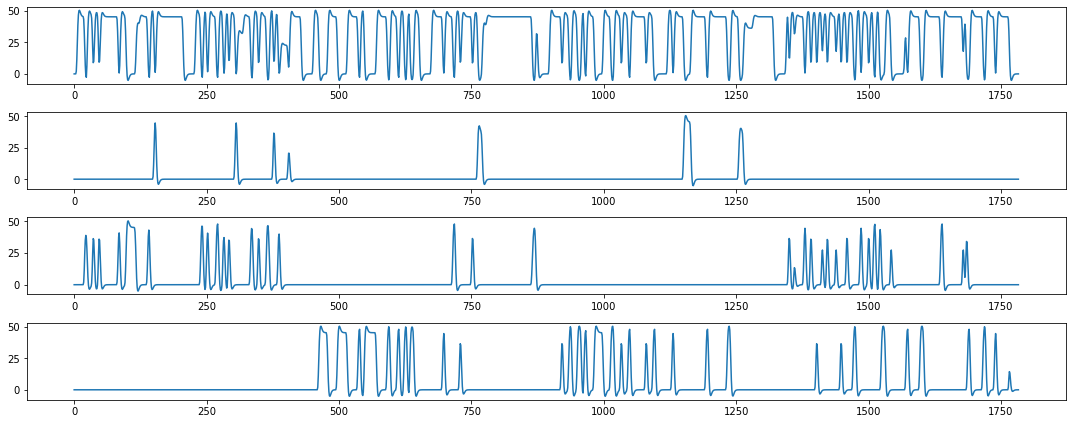

In [10]:
# check midlayer units
temp_data_ = design_matrix_alltowns[:,-num_road_types:]
temp_data = temp_data_[:,:]

n = temp_data.shape[1]
fig, axs = plt.subplots(n, 1,figsize=(15,6))
for i in range(n):
    tmp = temp_data[:,i]
    axs[i].plot(np.arange(len(tmp)), tmp)
    # axs[i].xaxis.set_ticks(np.arange(0, 200, 25) * 1.5)

fig.tight_layout()
plt.show()

##### load shared response

In [10]:
# shared response with SRM feature dimensions determined by number of voxels in each region
from scipy.io import loadmat

file_dir = project_dir+"/process/shared_region_dims/temp_data/"
matdic = loadmat(file_dir+"vit_"+ str(num_total_dims) + "_dims" +"_semgeo_shared_region_dims_list_optimal_hard_threshold.mat")

semgeo_shared_region_dims_list = matdic["semgeo_shared_region_dims_list"]
semgeo_shared_region_dims_list = semgeo_shared_region_dims_list[0]
print("shared response (shared_features, n_TRs) =", semgeo_shared_region_dims_list[0].shape)


shared response (shared_features, n_TRs) = (22, 3122)


In [11]:
# zscore shared response - non-effective
from scipy import stats

for i_brain_region in range(len(semgeo_shared_region_dims_list)):
  semgeo_shared_region_dims_list[i_brain_region] = stats.zscore(semgeo_shared_region_dims_list[i_brain_region], axis=1)

  if(np.isnan(semgeo_shared_region_dims_list[i_brain_region]).any()):
      print("semgeo_shared_region_dims_list[i_brain_region] contain NaN values")

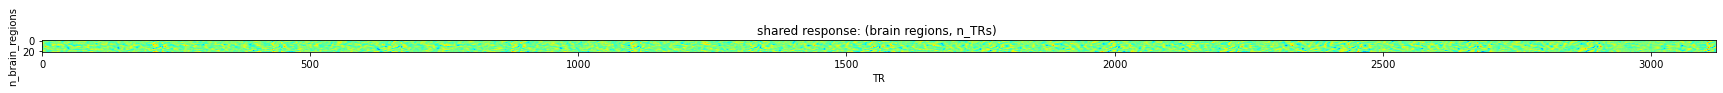

In [12]:
plt.figure(figsize=(30, 20))
plt.title('shared response: (brain regions, n_TRs) ')
plt.xlabel('TR')
plt.ylabel('n_brain_regions')
plt.imshow(semgeo_shared_region_dims_list[0], cmap='jet', vmin=-5, vmax=5)
# plt.colorbar()

## the roadtyes model

### train the roadtypes model


#### split training and testing data

In [ ]:
# take only one run for one town
num_run = 14
num_towns = 8

Y_train_list = []
Y_test_list = []

# take one run as test
for i_test_run in np.arange(num_towns):

  # spliting into train and test data
  Y_train_regions_list = []
  Y_test_regions_list = []
  Y_train_regions_array = np.empty((1400,0), float)
  Y_test_regions_array = np.empty((200,0), float)

  for i_region in range(0, len(semgeo_shared_region_dims_list)):

    temp_shared_response = semgeo_shared_region_dims_list[i_region]

    Y_data_temp = rearrange(temp_shared_response, 'i (j k) -> i j k', j=num_run)

    Y_data_array = np.concatenate((Y_data_temp[:,0:7,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video], 
              Y_data_temp[:,num_run-1:num_run,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]), axis=1)

    Y_train = Y_data_array[:,np.arange(num_towns)!=i_test_run,:]
    Y_test = Y_data_array[:,np.arange(num_towns)==i_test_run,:]

    Y_train = rearrange(Y_train, 'i j k -> i (j k) ')
    Y_test = rearrange(Y_test, 'i j k -> i (j k) ')

    Y_train = Y_train.T
    Y_test = Y_test.T

    Y_train_regions_array = np.append(Y_train_regions_array, Y_train, axis=1)
    Y_test_regions_array = np.append(Y_test_regions_array, Y_test, axis=1)

  Y_train_list.append(Y_train_regions_array)
  Y_test_list.append(Y_test_regions_array)

print("Y_train (n_TRs, shared_features) =", Y_train.shape)
print("Y_test (n_TRs, shared_features) =", Y_test.shape)

print("Y_train_regions_array (n_TRs, n_regions*shared_features) =", Y_train_regions_array.shape)
print("Y_test_regions_array (n_TRs, n_regions*shared_features) =", Y_test_regions_array.shape)

if(np.isnan(Y_train_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

if(np.isnan(Y_test_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

Y_train (n_TRs, shared_features) = (1400, 4)
Y_test (n_TRs, shared_features) = (200, 4)
Y_train_regions_array (n_TRs, n_regions*shared_features) = (1400, 887)
Y_test_regions_array (n_TRs, n_regions*shared_features) = (200, 887)


In [ ]:
X_data_temp = []
for i_run in np.arange(num_towns):
    data_temp = design_matrix_alltowns[223*i_run:223*(i_run+1),-(num_road_types):] # first 8, last num_semantic_categories
    data_temp = data_temp[start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video, 0:num_road_types]
    X_data_temp.append(data_temp)

X_data_temp = np.asarray(X_data_temp)

X_train_list = []
X_test_list = []

for i_test_run in np.arange(num_towns):

    X_train = X_data_temp[np.arange(num_towns)!=i_test_run,:,:]
    X_test = X_data_temp[np.arange(num_towns)==i_test_run,:,:]

    X_train = rearrange(X_train, 'i j k -> (i j) k')
    X_test = rearrange(X_test, 'i j k -> (i j) k')

    X_train_list.append(X_train)
    X_test_list.append(X_test)

    if(np.isnan(X_train).any()):
        print("X_train contain NaN values")

    if(np.isnan(X_test).any()):
        print("X_test contain NaN values")

print("X_train (n_TRs, n_latent_units) =", X_train.shape)
print("X_test (n_TRs, n_latent_units) =", X_test.shape)


X_train (n_TRs, n_latent_units) = (1400, 4)
X_test (n_TRs, n_latent_units) = (200, 4)


#### fit the model

In [ ]:
score_subs_list = []
Y_test_orig_list = []
Y_test_pred_list = []
model_kernel_ridgecv_list = []

for i_test_run in np.arange(num_towns):

    print("i_run:",i_test_run)
    
    # get X data
    X_train = X_train_list[i_test_run]
    X_test = X_test_list[i_test_run]

    # get Y data
    Y_train = Y_train_list[i_test_run]
    Y_test = Y_test_list[i_test_run]

    # import
    from sklearn.model_selection import check_cv
    from voxelwise_tutorials.utils import generate_leave_one_run_out

    # indice of first sample of each run
    run_onsets = []
    num_run_train=7
    for i in range(num_run_train):
        run_onsets.append(i*num_TRs_video)
    # print(run_onsets)

    n_samples_train = X_train.shape[0]
    cv = generate_leave_one_run_out(n_samples_train, run_onsets)
    cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(with_mean=False, with_std=False)

    from voxelwise_tutorials.delayer import Delayer
    delayer = Delayer(delays=[0])

    from himalaya.kernel_ridge import KernelRidgeCV
    from himalaya.ridge import RidgeCV
    from himalaya.backend import set_backend
    backend = set_backend("torch_cuda", on_error="warn")
    # print(backend)

    X_train = X_train.astype("float32")
    X_test = X_test.astype("float32")

    alphas = np.logspace(0, 20, 120)
    kernel_ridge_cv = RidgeCV(
        alphas=alphas, cv=cv, fit_intercept=True,
        solver_params=None) # try None

    from sklearn.pipeline import make_pipeline
    pipeline = make_pipeline(
        scaler,
        delayer,
        kernel_ridge_cv,
    )
    from sklearn import set_config
    set_config(display='diagram')  # requires scikit-learn 0.23
    _ = pipeline.fit(X_train, Y_train)

    # test
    scores = pipeline.score(X_test, Y_test)
    scores = backend.to_numpy(scores)
    score_subs_list.append(scores)

    # predict
    Y_test_predicted = pipeline.predict(X_test)
    Y_test_orig_list.append(Y_test)
    Y_test_pred_list.append(Y_test_predicted)

    # append ridgecv
    model_kernel_ridgecv_list.append(pipeline)

    # plot best alphas
    if glm_show_alpha == True:
        from himalaya.viz import plot_alphas_diagnostic
        import matplotlib.pyplot as plt
        best_alphas = backend.to_numpy(pipeline[-1].best_alphas_)
        print('best_alphas:',best_alphas.shape)
        plot_alphas_diagnostic(best_alphas=best_alphas, alphas=alphas)
        plt.show()

score_subs_array = np.array(score_subs_list)
print("score_subs_array.shape:",score_subs_array.shape)

Y_test_orig_midlayer_geometry = np.asarray(Y_test_orig_list)
print("Y_test_orig_midlayer_geometry.shape:",Y_test_orig_midlayer_geometry.shape)

Y_test_pred_midlayer_geometry = np.asarray(Y_test_pred_list)
print("Y_test_pred_midlayer_geometry.shape:",Y_test_pred_midlayer_geometry.shape)


i_run: 0
i_run: 1
i_run: 2
i_run: 3
i_run: 4
i_run: 5
i_run: 6
i_run: 7
score_subs_array.shape: (8, 887)
Y_test_orig_midlayer_geometry.shape: (8, 200, 887)
Y_test_pred_midlayer_geometry.shape: (8, 200, 887)


#### visualize the results

score shape: (8, 887)


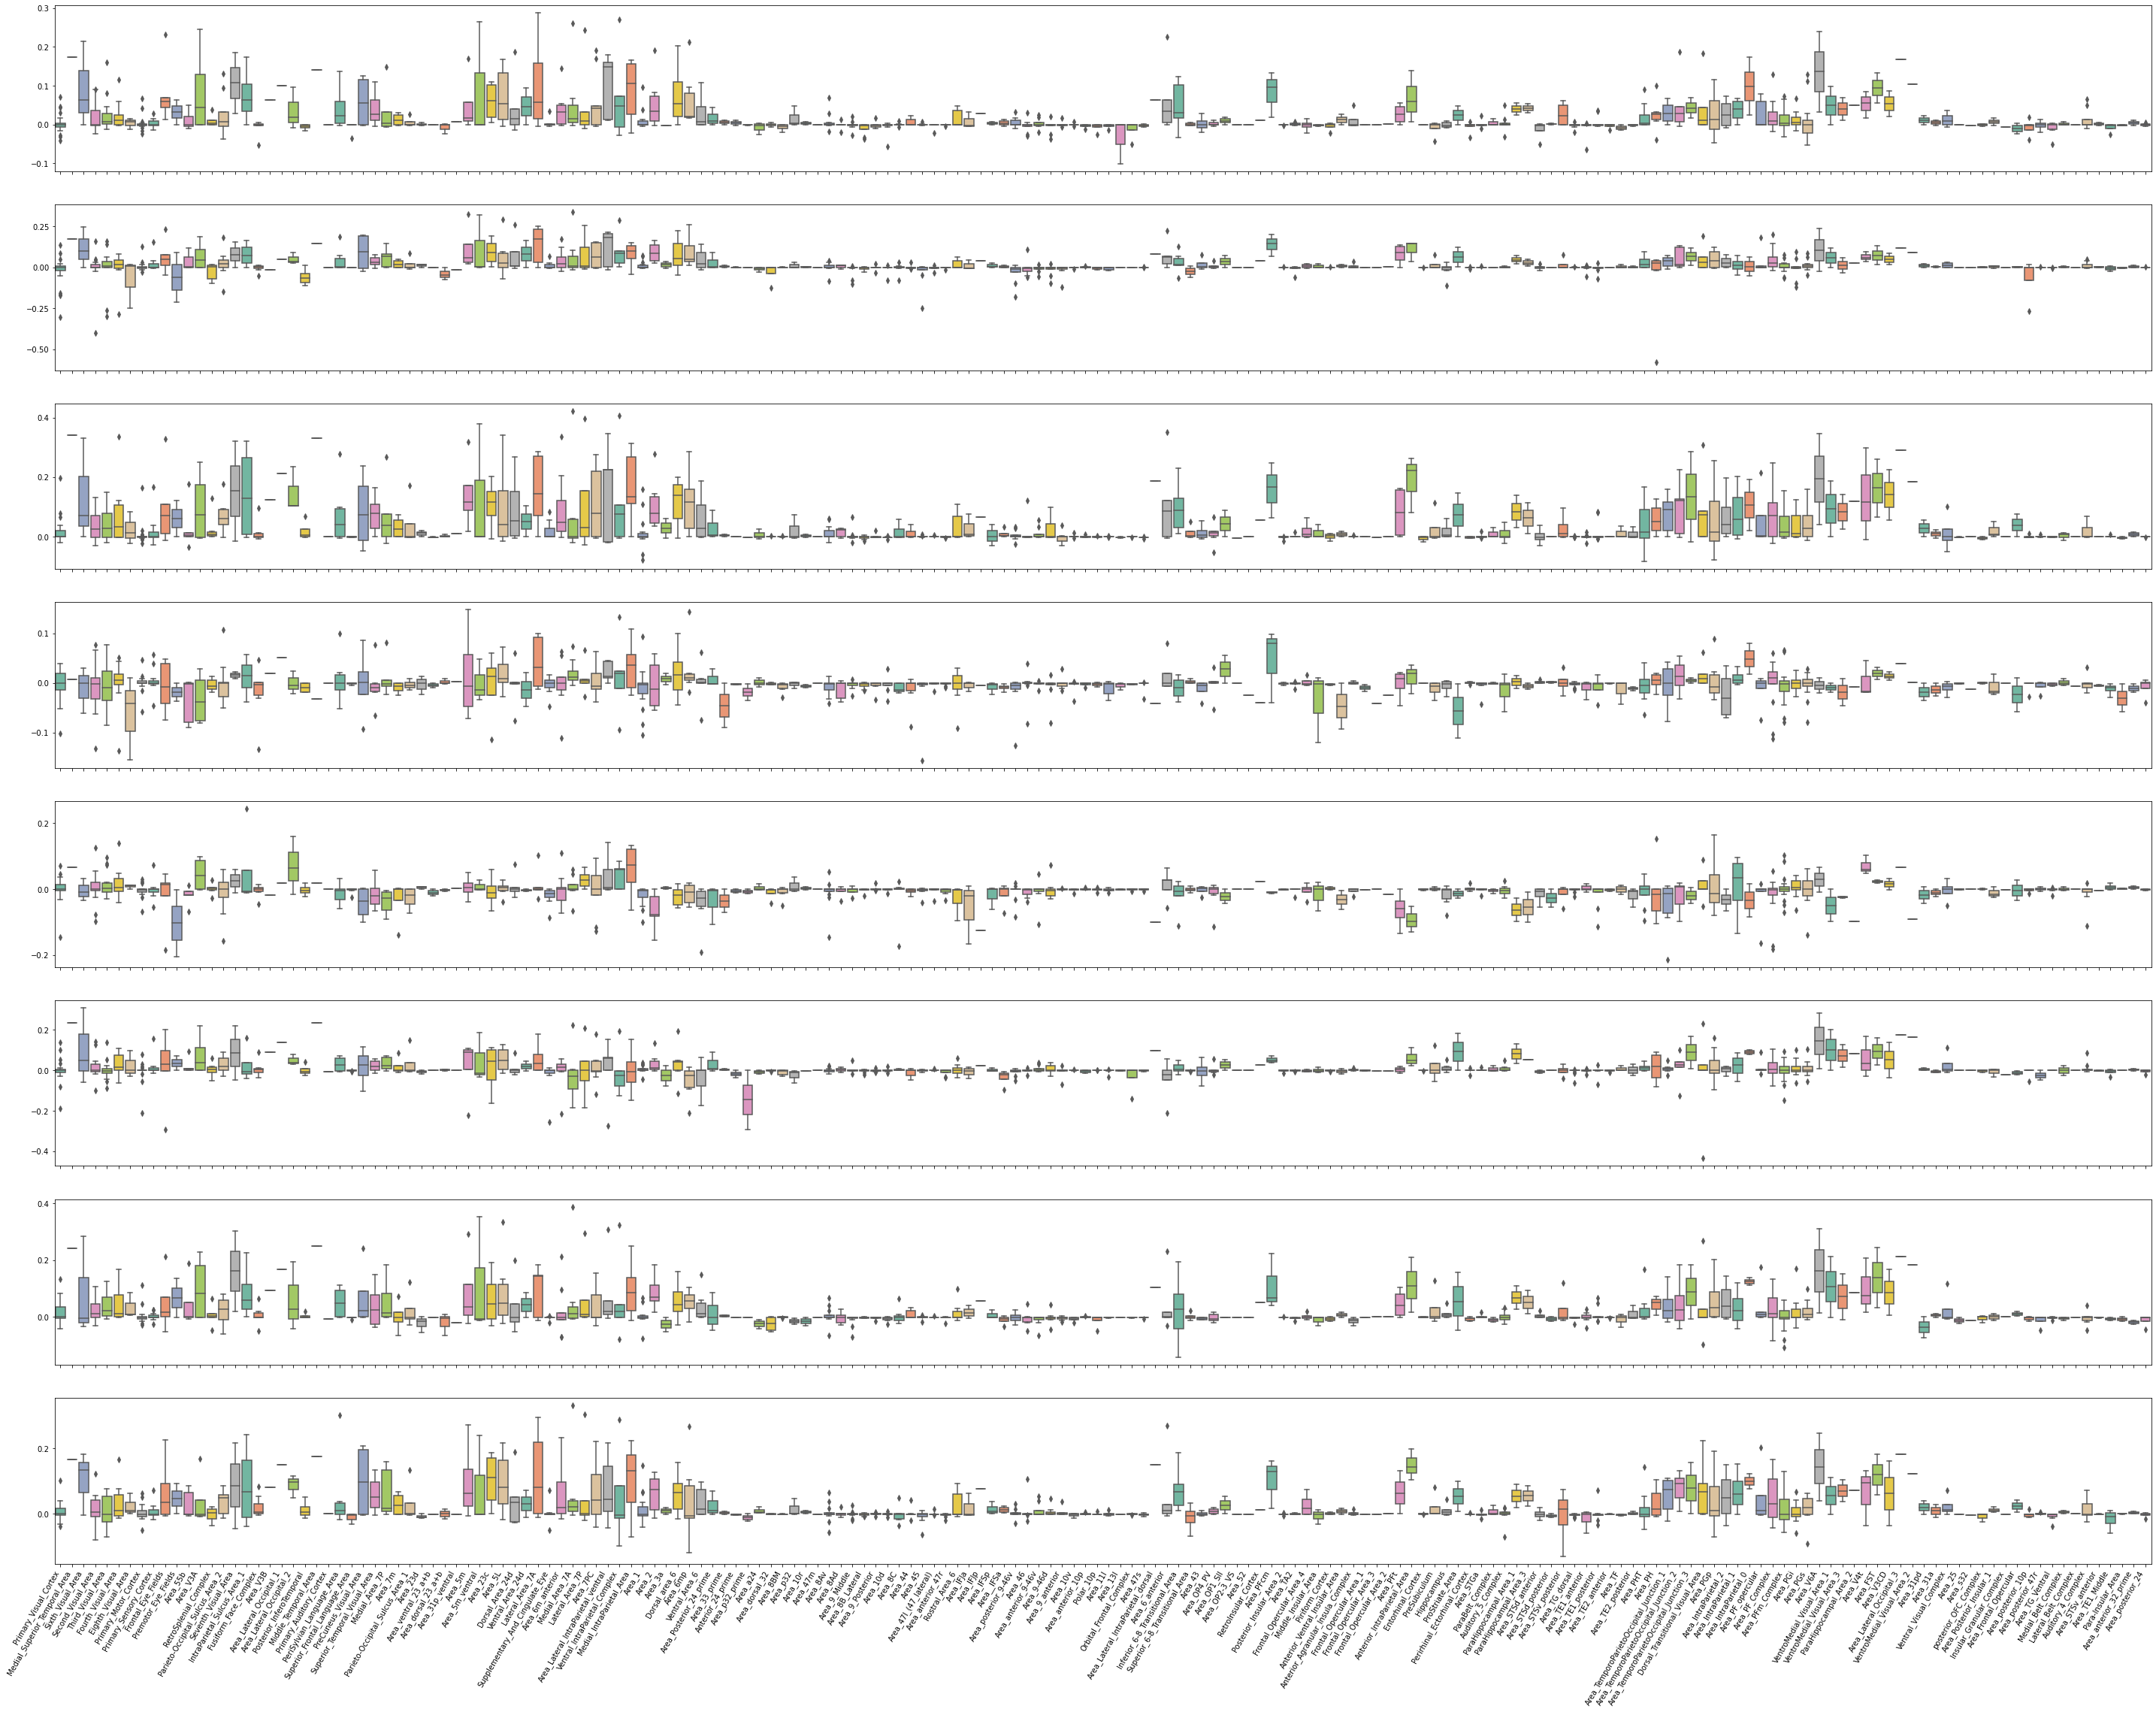

In [ ]:
temp_plot_score_regions_array = copy.deepcopy(score_subs_array)
print('score shape:',temp_plot_score_regions_array.shape)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

fig, axes = plt.subplots(nrows=temp_plot_score_regions_array.shape[0], ncols=1, figsize=(50, 60))
# fig.suptitle("Scores on test data", fontsize=18)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2
# plt.xlabel('Brain regions', fontsize=24)
# plt.ylabel('Scores', fontsize=16)

for i, ax in zip(range(temp_plot_score_regions_array.shape[0]), axes.flat):
    temp_plot_score_regions_list = []
    dim_accumulation = 0
    for i_region in range(0, len(brain_region_name_list)):
        dim_features = region_voxels_array[i_region]
        current_region_scores = temp_plot_score_regions_array[i, dim_accumulation:dim_accumulation + dim_features]
        dim_accumulation = dim_accumulation + dim_features
        # current_region_scores[current_region_scores < -0.05] = -0.05
        temp_plot_score_regions_list.append(current_region_scores)
        
    boxplt = sns.boxplot(data=temp_plot_score_regions_list, palette="Set2", ax=ax)
    boxplt.set_xticklabels([])
ax.set_xticklabels(brain_region_name_list)
plt.xticks(rotation=60, ha='right')
plt.subplots_adjust(bottom=0.4)
plt.show()

# fig.savefig('img/'+'semgeo_whole_brain_regions_test_glm_score.png', format='png', dpi=500)


##### explainable variance of dims

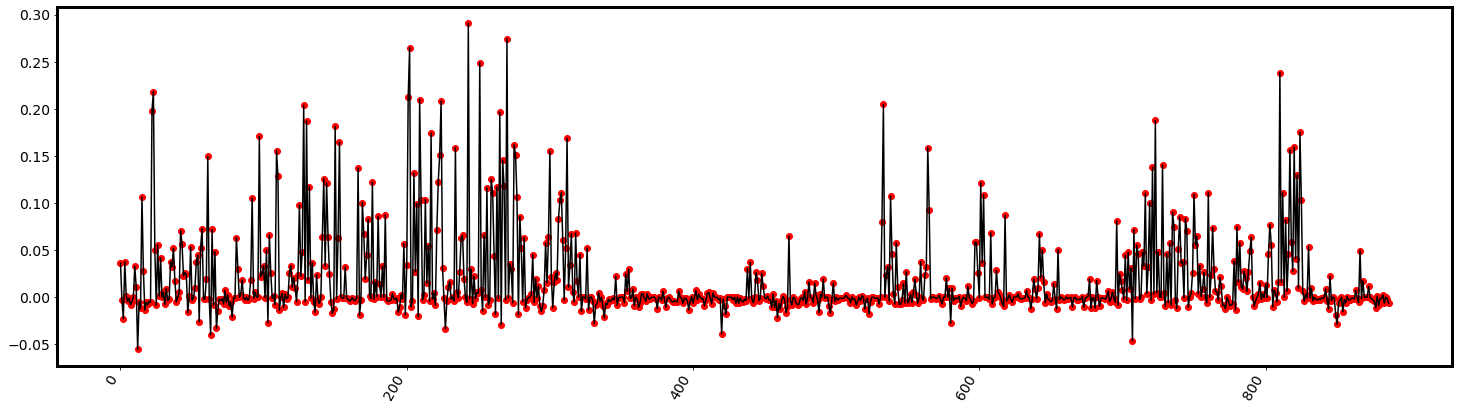

In [ ]:
from sklearn.metrics import r2_score

# ve for each brain regions
dim_accumulation = 0
sub_score = np.zeros((Y_test_pred_midlayer_geometry.shape[2],), dtype=float)

for i_dim in range(0, Y_test_pred_midlayer_geometry.shape[2]):

    error = 0
    var = 0
    for i_test_run in np.arange(num_towns):

        Y_test = Y_test_orig_list[i_test_run]
        Y_test_predicted = Y_test_pred_list[i_test_run]

        y_true = Y_test[:, i_dim:i_dim + 1]
        y_pred = Y_test_predicted[:, i_dim:i_dim + 1]
        
        # error = error + ((y_true - y_pred) ** 2.0).sum()
        # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

        error = error + (np.var(y_true - y_pred) ).sum()
        var = var + (np.var(y_true - y_true.mean(0)) ).sum()


    # dim_accumulation = dim_accumulation + dim_features

    sub_score[i_dim] = 1.0 - error / var
    
# show summary ev runs
explained_variance_single_dim_roadtypes = copy.deepcopy(np.asarray(sub_score))

plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3
fig = plt.figure(figsize =(25, 6))
plt.plot(np.arange(0,Y_test_pred_midlayer_geometry.shape[2]), explained_variance_single_dim_roadtypes,'ro')
plt.plot(np.arange(0,Y_test_pred_midlayer_geometry.shape[2]), explained_variance_single_dim_roadtypes,'k-')
# plt.xticks(np.arange(0,len(brain_region_name_list)), brain_region_name_list, rotation='vertical', fontsize=8)
plt.xticks(rotation=60, ha='right')
# plt.margins(0.01)
plt.subplots_adjust(bottom=0.05)
plt.show()
# fig.savefig('img/'+'shared_ae-whole_brain_regions_glm_score.eps', format='eps', dpi=900)
# fig.savefig('img/'+'semgeo_shared_ae-whole_brain_regions_glm_score.png', dpi=500)


In [ ]:
from scipy.io import savemat
import copy

print("explained_variance_single_dim_roadtypes shape:", explained_variance_single_dim_roadtypes.shape)

matdic = {"explained_variance_single_dim_roadtypes": explained_variance_single_dim_roadtypes}
project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/spatial_process"

file_dir = project_dir+"/process/roadtypes/temp_data/"
savemat(file_dir+"vit_"+ str(num_total_dims) + "_dims"+ "_single_dim_roadtypes_ev_score_brain_regions.mat", matdic)

print("num of effective dims:", np.sum(explained_variance_single_dim_roadtypes > 0.0))


explained_variance_single_dim_roadtypes shape: (887,)
num of effective dims: 375


#### explainable variance with p-values 

##### ev on cross all runs

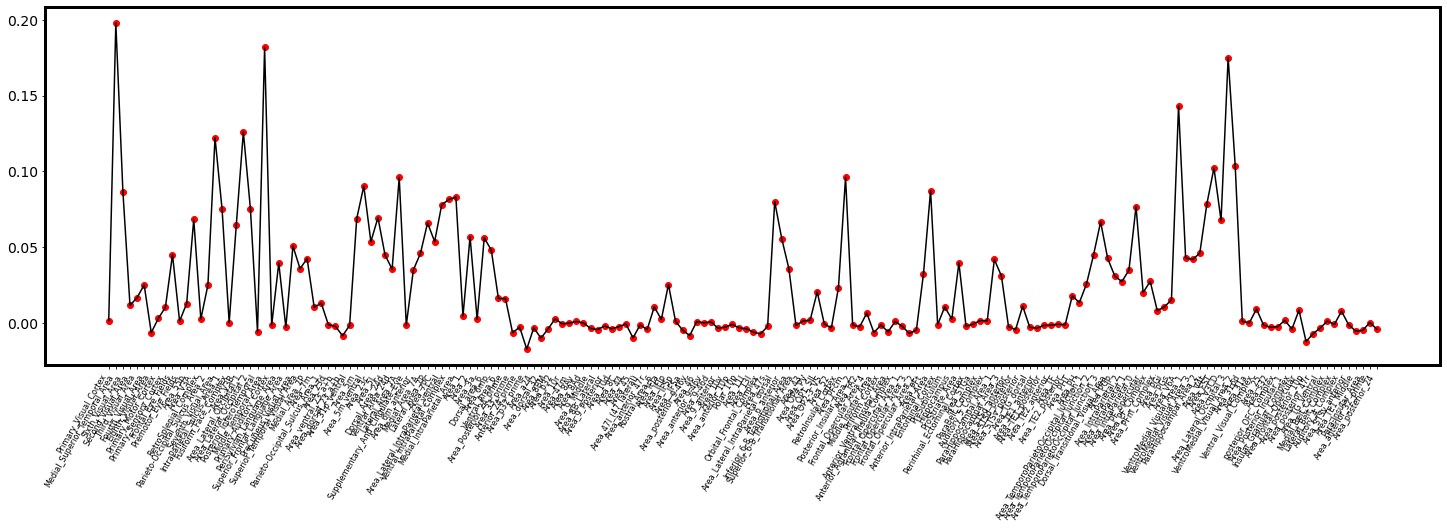

In [ ]:
from sklearn.metrics import r2_score

# ve for each brain regions
dim_accumulation = 0
sub_score = np.zeros((len(brain_region_name_list),), dtype=float)

for i_region in range(0, len(brain_region_name_list)):
    dim_features = region_voxels_array[i_region]

    error = 0
    var = 0
    for i_test_run in np.arange(num_towns):

        Y_test = Y_test_orig_list[i_test_run]
        Y_test_predicted = Y_test_pred_list[i_test_run]

        y_true = Y_test[:, dim_accumulation:dim_accumulation + dim_features]
        y_pred = Y_test_predicted[:, dim_accumulation:dim_accumulation + dim_features]
        
        # error = error + ((y_true - y_pred) ** 2.0).sum()
        # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

        error = error + (np.var(y_true - y_pred) ).sum()
        var = var + (np.var(y_true - y_true.mean(0)) ).sum()

    dim_accumulation = dim_accumulation + dim_features

    # each_sub_score[i_region] = r2_score(y_true, y_pred)
    # error = ((y_true - y_pred) ** 2.0).sum()
    # var = ((y_true - y_true.mean(0)) ** 2.0).sum()
    sub_score[i_region] = 1.0 - error / var
    
# show summary ev runs
explained_variance_roadtypes = copy.deepcopy(np.asarray(sub_score))

plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3
fig = plt.figure(figsize =(25, 6))
plt.plot(np.arange(0,len(brain_region_name_list)), explained_variance_roadtypes,'ro')
plt.plot(np.arange(0,len(brain_region_name_list)), explained_variance_roadtypes,'k-')
plt.xticks(np.arange(0,len(brain_region_name_list)), brain_region_name_list, rotation='vertical', fontsize=8)
plt.xticks(rotation=60, ha='right')
# plt.margins(0.01)
plt.subplots_adjust(bottom=0.05)
plt.show()
# fig.savefig('img/'+'shared_ae-whole_brain_regions_glm_score.eps', format='eps', dpi=900)
# fig.savefig('img/'+'semgeo_shared_ae-whole_brain_regions_glm_score.png', dpi=500)


#### manually select brain regions and corresponding indices

name of areas and corresponding ID
1. name
early visual (V1, V2, V3),
higher visual (V4, V3A, V3B, V3CD, V6, V6A, V7, DVT, POS1, POS2, V8),
area 7 (7m, 7Pm, 7Am, 7PL, 7AL, 7PC)
IP area (IPS1, IP0, IP1, IP2, MIP, VIP, AIP, LIPv, LIPd)
precentral gyrus (PGs, PGp)
MT+ (LO1, LO2, LO3, V4t, MT, MST, FST)
medial (TPOJ1, TPOJ2, TPOJ3, STV, PSL, PF, PFt, PFcm, RI)
ventral (VMV1, VMV2, VMV3, VVC, ProS, PHA1, PHA2, PHA3, PresS, H)

2. ID
early visual (1, 4, 5),
higher visual (6, 13, 19, 158, 3, 152, 16, 142, 211, 15, 7),
area 7 (30, 29, 45, 46, 222, 227)
IP area (17, 146, 145, 144, 230, 229, 297, 48, 95)
precentral gyrus (151, 143)
MT+ (200, 201, 339, 156, 203, 2, 157)
medial (319, 320, 321, 28, 205, 148, 296, 105, 284)
ventral (333, 340, 334, 343, 121, 126, 155, 307, 119, 120)

3. merge
brain_region_name_early_visual = [V1, V2, V3]
brain_region_id_early_visual = [1, 4, 5]

brain_region_name_higher_visual = [V4, V3A, V3B, V3CD, V6, V6A, V7, DVT, POS1, POS2, V8]
brain_region_id_higher_visual = [6, 13, 19, 158, 3, 152, 16, 142, 211, 15, 7]

brain_region_name_area_7 = [7m, 7Pm, 7Am, 7PL, 7AL, 7PC]
brain_region_id_area_7 = [30, 29, 45, 46, 222, 227]

brain_region_name_IP_area = [IPS1, IP0, IP1, IP2, MIP, VIP, AIP, LIPv, LIPd]
brain_region_id_IP_area = [17, 146, 145, 144, 230, 229, 297, 48, 95]

brain_region_name_precentral_gyrus = [PGs, PGp]
brain_region_id_precentral_gyrus = [151, 143]

brain_region_name_MT_plus = [LO1, LO2, LO3, V4t, MT, MST, FST]
brain_region_id_MT_plus = [200, 201, 339, 156, 203, 2, 157]

brain_region_name_medial_visual = [TPOJ1, TPOJ2, TPOJ3, STV, PSL, PF, PFt, PFcm, RI]
brain_region_id_medial_visual = [319, 320, 321, 28, 205, 148, 296, 105, 284]

brain_region_name_ventral_visual = [VMV1, VMV2, VMV3, VVC, ProS, PHA1, PHA2, PHA3, PresS, H]
brain_region_id_ventral_visual = [333, 340, 334, 343, 121, 126, 155, 307, 119, 120]



In [ ]:
# Lists of brain region names and IDs
brain_region_name_early_visual = ['V1', 'V2', 'V3']
brain_region_id_early_visual = [1, 4, 5]

brain_region_name_higher_visual = ['V4', 'V3A', 'V3B', 'V3CD', 'V6', 'V6A', 'V7', 'DVT', 'POS1', 'POS2', 'V8']
brain_region_id_higher_visual = [6, 13, 19, 158, 3, 152, 16, 142, 31, 15, 7]

brain_region_name_area_7 = ['7m', '7Pm', '7Am', '7PL', '7AL', '7PC']
brain_region_id_area_7 = [30, 29, 45, 46, 42, 47]

brain_region_name_IP_area = ['IPS1', 'IP0', 'IP1', 'IP2', 'MIP', 'VIP', 'AIP', 'LIPv', 'LIPd']
brain_region_id_IP_area = [17, 146, 145, 144, 50, 49, 117, 48, 95]

brain_region_name_precentral_gyrus = ['PGs', 'PGp']
brain_region_id_precentral_gyrus = [151, 143]

brain_region_name_MT_plus = ['LO1', 'LO2', 'LO3', 'V4t', 'MT', 'MST', 'FST']
brain_region_id_MT_plus = [20, 21, 159, 156, 23, 2, 157]

brain_region_name_medial_visual = ['TPOJ1', 'TPOJ2', 'TPOJ3', 'STV', 'PSL', 'PF', 'PFt', 'PFcm', 'RI']
brain_region_id_medial_visual = [139, 140, 141, 28, 25, 148, 116, 105, 104]

brain_region_name_ventral_visual = ['VMV1', 'VMV2', 'VMV3', 'VVC', 'ProS', 'PHA1', 'PHA2', 'PHA3', 'PresS', 'H']
brain_region_id_ventral_visual = [153, 160, 154, 163, 121, 126, 155, 127, 119, 120]

selected_brain_region_name_list = (
    brain_region_name_early_visual +
    brain_region_name_higher_visual +
    brain_region_name_area_7 +
    brain_region_name_IP_area +
    brain_region_name_precentral_gyrus +
    brain_region_name_MT_plus +
    brain_region_name_medial_visual +
    brain_region_name_ventral_visual
)
selected_brain_region_id_list = (
    brain_region_id_early_visual +
    brain_region_id_higher_visual +
    brain_region_id_area_7 +
    brain_region_id_IP_area +
    brain_region_id_precentral_gyrus +
    brain_region_id_MT_plus +
    brain_region_id_medial_visual +
    brain_region_id_ventral_visual
)

##### comparison between roadtypes and geometry

In [ ]:
from scipy.io import loadmat
import copy

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
file_dir = project_dir+"/process/shared_glm/temp_data/"
matdic = loadmat(file_dir+"vit_selected_midlayer_geometry_ev_score_brain_regions.mat")
explained_variance_midlayer_geometry = matdic["explained_variance_midlayer_geometry"]
explained_variance_single_dim_midlayer_geometry = matdic["explained_variance_single_dim_midlayer_geometry"]

In [ ]:
print("explained_variance_midlayer_geometry max value:", np.max(explained_variance_midlayer_geometry))
print("explained_variance_roadtypes max value:", np.max(explained_variance_roadtypes))

In [ ]:
import numpy as np
import copy 
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Times New Roman'

# Sample data
categories = selected_brain_region_name_list

shifted_selected_brain_region_id_list = [x - 1 for x in selected_brain_region_id_list]

group1_values = copy.deepcopy(np.squeeze(explained_variance_midlayer_geometry))
group1_values = group1_values[shifted_selected_brain_region_id_list]

group2_values = copy.deepcopy(explained_variance_roadtypes)
group2_values = group2_values[shifted_selected_brain_region_id_list]

# Calculate the width for each group
bar_width = 0.35

# Create an array of indices for the x-axis ticks
x = np.arange(len(categories))

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(20,9))

# Plot the bars for Group 1
ax.bar(x - bar_width/2, group1_values, bar_width, label='Geometry')

# Plot the bars for Group 2
ax.bar(x + bar_width/2, group2_values, bar_width, label='Roadtypes')

# Set labels, title, and legend
ax.set_xlabel('Brain regions')
ax.set_ylabel('Explainable variance')
# ax.set_title('Grouped Bar Chart')

ax.tick_params(axis='y', labelsize=18)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=90, ha='right', fontsize=18)
ax.legend(bbox_to_anchor=(0.5, -0.2),loc='upper center')
plt.subplots_adjust(bottom=0.3)  # Adjust the value as needed
# plt.subplots_adjust(left=0.0, right=1.0)

# Display the plot
plt.show()
fig.savefig('../shared_glm/img/'+'ev_comparison_bewteen_geometry_and_roadtypes.png', dpi=500)


#### permutation before cross-validation


##### the geometry permutation model

In [ ]:
# ve for each brain regions
sub_score_shuffle_list = []

Y_test_orig_permutation_list = []
Y_test_pred_permutation_list = []

sub_score = np.zeros((len(brain_region_name_list), shuffle_num_times,), dtype=float)

for i_shuffle in range(shuffle_num_times):

    np.random.seed(i_shuffle)
    single_run_TRs_video_indices = np.arange(num_TRs_video)
    X_test_indices_2 = np.arange(X_test_list[0].shape[1])
    Y_test_indices_2 = np.arange(Y_test_list[0].shape[1])
    np.random.shuffle(single_run_TRs_video_indices)

    train_run_TRs_video_indices = np.zeros(((num_towns - 1)*num_TRs_video,), dtype=int)
    for i_train_run in range(num_towns-1):
        i_run_TRs_video_indices = copy.deepcopy(single_run_TRs_video_indices)
        np.random.shuffle(i_run_TRs_video_indices)
        train_run_TRs_video_indices[i_train_run*num_TRs_video:(i_train_run+1)*num_TRs_video] \
            = i_run_TRs_video_indices + i_train_run*num_TRs_video

    if i_shuffle%10 == 0:
        print("i_shuffle:",i_shuffle)

    i_Y_test_orig_permutation_list = []
    i_Y_test_pred_permutation_list = []

    for i_test_run in np.arange(num_towns):

        # print("i_run:",i_test_run)
        
        # get X data
        X_train = X_train_list[i_test_run]
        # X_train_permutation = X_train[train_run_TRs_video_indices[:,None], X_test_indices_2[None,:]]
        X_train_permutation = X_train

        X_test = X_test_list[i_test_run]
        # X_test_permutation = X_test[single_run_TRs_video_indices[:,None], X_test_indices_2[None,:]]
        X_test_permutation = X_test

        # get Y data
        Y_train = Y_train_list[i_test_run]
        Y_train_permutation = Y_train[train_run_TRs_video_indices[:,None], Y_test_indices_2[None,:]]

        Y_test = Y_test_list[i_test_run]
        Y_test_permutation = Y_test[single_run_TRs_video_indices[:,None], Y_test_indices_2[None,:]]

        # import
        from sklearn.model_selection import check_cv
        from voxelwise_tutorials.utils import generate_leave_one_run_out

        # indice of first sample of each run
        run_onsets = []
        num_run_train=7
        for i in range(num_run_train):
            run_onsets.append(i*num_TRs_video)
        # print(run_onsets)

        n_samples_train = X_train.shape[0]
        cv = generate_leave_one_run_out(n_samples_train, run_onsets)
        cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler(with_mean=False, with_std=False)

        from voxelwise_tutorials.delayer import Delayer
        delayer = Delayer(delays=[0])

        from himalaya.kernel_ridge import KernelRidgeCV
        from himalaya.ridge import RidgeCV
        from himalaya.backend import set_backend
        backend = set_backend("torch_cuda", on_error="warn")
        # print(backend)

        X_train_permutation = X_train_permutation.astype("float32")
        X_test_permutation = X_test_permutation.astype("float32")

        alphas = np.logspace(-3, 20, 120)
        kernel_ridge_cv = RidgeCV(
            alphas=alphas, cv=cv, fit_intercept=True,
            solver_params=None) # try None

        from sklearn.pipeline import make_pipeline
        pipeline = make_pipeline(
            scaler,
            delayer,
            kernel_ridge_cv,
        )
        from sklearn import set_config
        set_config(display='diagram')  # requires scikit-learn 0.23
        _ = pipeline.fit(X_train_permutation, Y_train_permutation)

        # primal_coef = pipeline[-1].get_primal_coef()
        # primal_coef = backend.to_numpy(primal_coef)
        # print("(n_delays * n_features, n_voxels) =", primal_coef.shape)
        # print("coef mean:",np.mean(primal_coef.flatten()))

        # predict
        Y_test_permutation_predicted = pipeline.predict(X_test_permutation)
        i_Y_test_orig_permutation_list.append(Y_test_permutation)
        i_Y_test_pred_permutation_list.append(Y_test_permutation_predicted)

    # calc ev for each region in a permutation
    dim_accumulation = 0
    for i_region in range(0, len(brain_region_name_list)):

        dim_features = region_voxels_array[i_region]

        error = 0
        var = 0
        for i_test_run in np.arange(num_towns):

            Y_test = i_Y_test_orig_permutation_list[i_test_run]
            Y_test_predicted = i_Y_test_pred_permutation_list[i_test_run]

            y_true = Y_test[:, dim_accumulation:dim_accumulation + dim_features]
            y_pred = Y_test_predicted[:, dim_accumulation:dim_accumulation + dim_features]
            
            # error = error + ((y_true - y_pred) ** 2.0).sum()
            # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

            error = error + (np.var(y_true - y_pred) ).sum()
            var = var + (np.var(y_true - y_true.mean(0)) ).sum()

        sub_score[i_region][i_shuffle] = 1.0 - error / var

        dim_accumulation = dim_accumulation + dim_features

explained_variance_each_shuffle_roadtypes = copy.deepcopy(np.asarray(sub_score))
print("explained_variance_each_shuffle_roadtypes shape:", explained_variance_each_shuffle_roadtypes.shape)


i_shuffle: 0
i_shuffle: 10
i_shuffle: 20
i_shuffle: 30
i_shuffle: 40
i_shuffle: 50
i_shuffle: 60
i_shuffle: 70
i_shuffle: 80
i_shuffle: 90
explained_variance_each_shuffle_roadtypes shape: (180, 100)


In [ ]:
from scipy.io import savemat
import copy

print("explained_variance_each_shuffle_roadtypes shape:", explained_variance_each_shuffle_roadtypes.shape)

matdic = {"explained_variance_each_shuffle_roadtypes": explained_variance_each_shuffle_roadtypes}
project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/spatial_process"

file_dir = project_dir+"/process/roadtypes/temp_data/"
savemat(file_dir+"vit_"+ str(num_total_dims) + "_dims"+ "_shareddims_explained_variance_each_shuffle_roadtypes.mat", matdic)


explained_variance_each_shuffle_roadtypes shape: (180, 100)


In [ ]:
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/spatial_process"
file_dir = project_dir+"/process/roadtypes/temp_data/"
matdic = loadmat(file_dir+"vit_"+ str(num_total_dims) + "_dims"+ "_shareddims_explained_variance_each_shuffle_roadtypes.mat")

explained_variance_each_shuffle_roadtypes = matdic["explained_variance_each_shuffle_roadtypes"]
print("explained_variance_each_shuffle_roadtypes shape =", explained_variance_each_shuffle_roadtypes.shape)

explained_variance_each_shuffle_roadtypes shape = (180, 100)


##### permuation explainable variance (each shuffle) - calc p-values

explained_variance_each_shuffle_roadtypes.shape: (180, 100)
explained_variance_roadtypes.shape (180,)
num_rejects: 108
pvals less than: 108


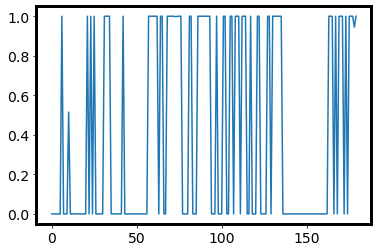

In [ ]:
print("explained_variance_each_shuffle_roadtypes.shape:",explained_variance_each_shuffle_roadtypes.shape)
print("explained_variance_roadtypes.shape",explained_variance_roadtypes.shape)

temp_shuffle_score = copy.deepcopy(explained_variance_each_shuffle_roadtypes.T)

raw_pvalue_list = []
for i_region in range(temp_shuffle_score.shape[1]):
  raw_pvalue = np.sum(temp_shuffle_score[:,i_region] > explained_variance_roadtypes[i_region])
  raw_pvalue_list.append(raw_pvalue)

raw_pvalue_array = np.asarray(raw_pvalue_list)/temp_shuffle_score.shape[0]

#-----multiple test
import statsmodels

# multiple test corrected for p-values
rejects, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(raw_pvalue_array)

num_rejects = np.sum(rejects == True)
print("num_rejects:", num_rejects)

plt.plot(pvals_corrected)
print("pvals less than:", np.sum(pvals_corrected < 0.05))

##### permuation explainable variance (each shuffle) - visualize before multipletests

sub_score_shuffle_array shape: (100, 180)


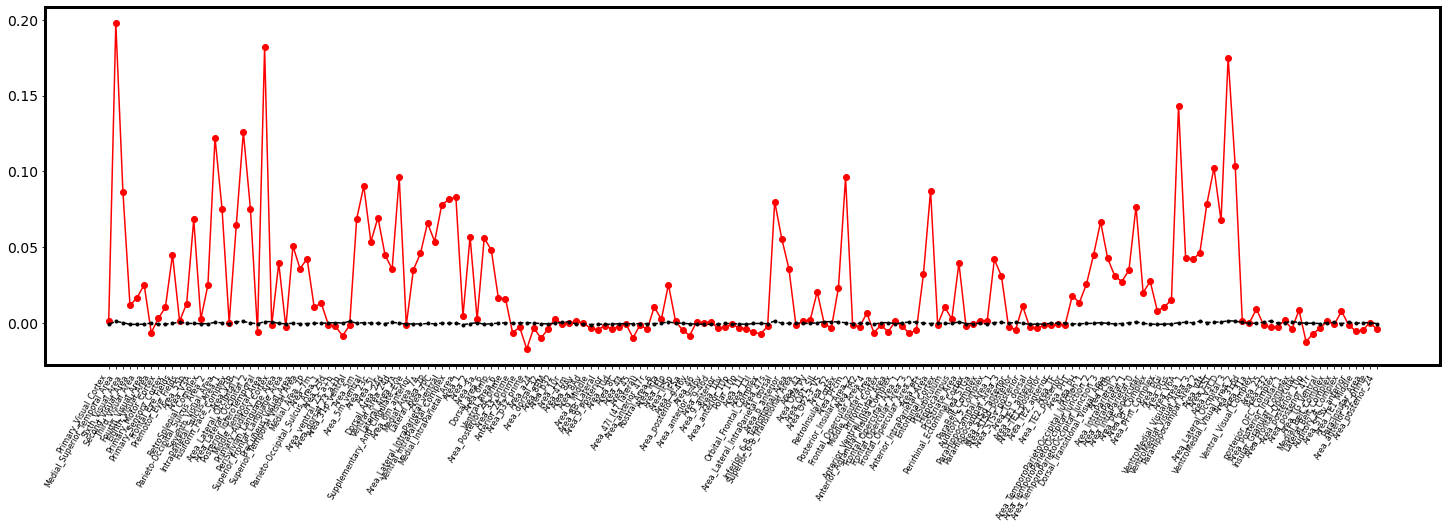

In [ ]:
roadtypes_sub_score_percentile = np.percentile(temp_shuffle_score, 95, axis=0)
print('sub_score_shuffle_array shape:',temp_shuffle_score.shape)

# show summary ev runs
explained_variance_roadtypes_shuffle_percentile = copy.deepcopy(roadtypes_sub_score_percentile)

plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3
fig = plt.figure(figsize =(25, 6))
plt.plot(np.arange(0,len(brain_region_name_list)), explained_variance_roadtypes,'r-o')
plt.plot(np.arange(0,len(brain_region_name_list)), explained_variance_roadtypes_shuffle_percentile,'k.--')
plt.xticks(np.arange(0,len(brain_region_name_list)), brain_region_name_list, rotation='vertical', fontsize=8)
plt.xticks(rotation=60, ha='right')
# plt.margins(0.01)
plt.subplots_adjust(bottom=0.05)
plt.show()
# fig.savefig('img/'+'shared_ae-whole_brain_regions_glm_score.eps', format='eps', dpi=900)
# fig.savefig('img/'+'semgeo_shared_ae-whole_brain_regions_glm_score.png', dpi=500)

##### permuation explainable variance (each shuffle) - save and load for wb

In [ ]:
from scipy.io import savemat
import copy

print("sub_score shape:", explained_variance_roadtypes.shape)

if pvals_corrected is None:
  matdic = {"sub_score": explained_variance_roadtypes}
else:
  matdic = {"sub_score": explained_variance_roadtypes,
            "pvals_corrected": pvals_corrected}
project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/spatial_process"

file_dir = project_dir+"/process/shared_region_dims/temp_data/"
savemat(file_dir+"vit_"+ str(num_total_dims) + "_dims"+ "_roadtypes_ev_score_brain_regions.mat", matdic)


sub_score shape: (180,)


### train a logistic regression to predict road types


#### load road label

In [ ]:
from scipy.io import loadmat

save_dir = project_dir+"/process/roadtypes/"

num_towns = 8
road_labels_list = []
for i_town in range(num_towns):
  matdic = loadmat(save_dir+"road_labels_town_"+str(i_town)+".mat")

  i_road_labels_array = np.squeeze(matdic["road_labels_array"])
  road_labels_list.append(i_road_labels_array)

road_labels_array = np.asarray(road_labels_list)
road_labels_array = np.swapaxes(road_labels_array, 2, 1)
road_labels_array = road_labels_array[:,:,0:4]
print("units_latent_space shape (roadtypes, num_TRs) =", road_labels_array.shape)

num_road_types = road_labels_array.shape[2]
print("num_road_types =", num_road_types)

road_labels_classes = np.argmax(road_labels_array, axis=2)
print("road_labels_classes shape (num_town, num_TRs) =", road_labels_classes.shape)

road_labels_classes_train = np.concatenate((road_labels_classes[0:6,:],road_labels_classes[7:8,:]), axis=0)
road_labels_classes_train = np.squeeze(road_labels_classes_train.reshape(-1,1))
print("road_labels_classes_train shape (num_towns*num_TRs) =", road_labels_classes_train.shape)

road_labels_classes_test = road_labels_classes[6,:]
print("road_labels_classes_test shape (num_towns*num_TRs) =", road_labels_classes_test.shape)


units_latent_space shape (roadtypes, num_TRs) = (8, 200, 4)
num_road_types = 4
road_labels_classes shape (num_town, num_TRs) = (8, 200)
road_labels_classes_train shape (num_towns*num_TRs) = (1400,)
road_labels_classes_test shape (num_towns*num_TRs) = (200,)


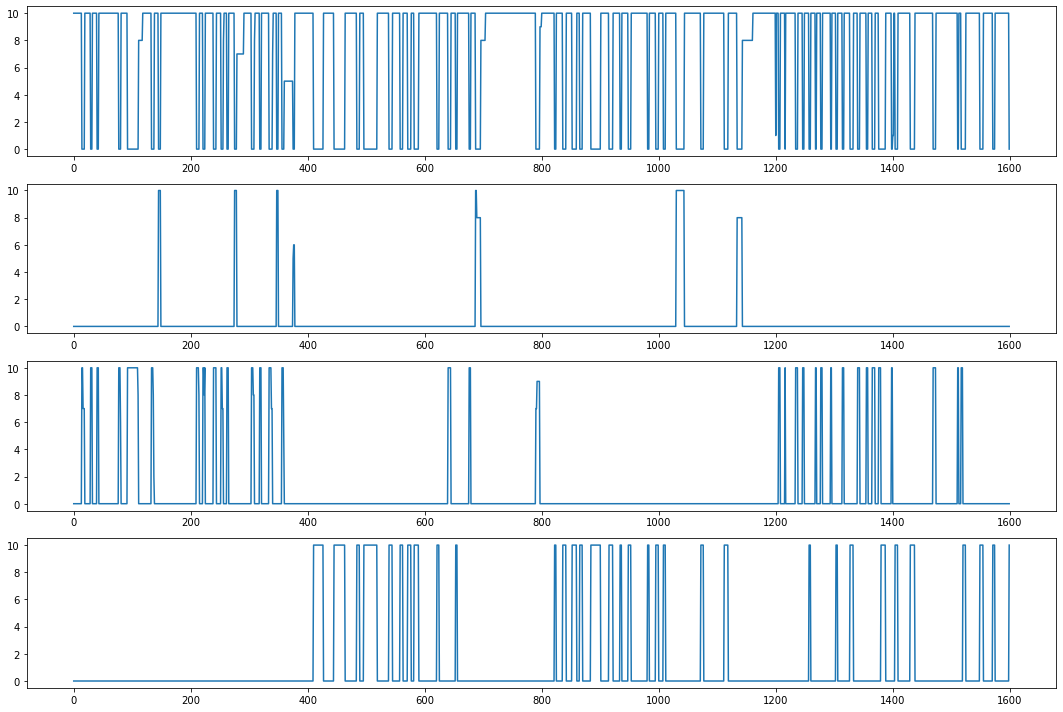

In [ ]:
temp_road_labels_array = road_labels_array.reshape(-1, num_road_types)
temp_data = temp_road_labels_array

n = temp_data.shape[1]
fig, axs = plt.subplots(n, 1,figsize=(15,10))
for i in range(n):
    tmp = temp_data[:,i]
    axs[i].plot(np.arange(len(tmp)), tmp)
    # axs[i].xaxis.set_ticks(np.arange(0, 200, 25) * 1.5)

fig.tight_layout()
plt.show()

##### get the fMRI data dim mask from the roadtypes model


In [ ]:
# get mask from the midlayer geometry model
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/spatial_process"

file_dir = project_dir+"/process/roadtypes/temp_data/"
file_str = "vit_"+ str(num_total_dims) + "_dims"+ "_single_dim_roadtypes_ev_score_brain_regions"

matdic = loadmat(file_dir+file_str+".mat")
explained_variance_single_dim_roadtypes = matdic["explained_variance_single_dim_roadtypes"]

explained_variance_single_dim_roadtypes_threshold = 0.0
print("num of effective dims:", np.sum(explained_variance_single_dim_roadtypes > explained_variance_single_dim_roadtypes_threshold))

indices_Y_pvals_corrected_single_dim_midlayer_geometry = np.squeeze(explained_variance_single_dim_roadtypes > explained_variance_single_dim_roadtypes_threshold)
print(indices_Y_pvals_corrected_single_dim_midlayer_geometry.shape)

num of effective dims: 375
(887,)


#### split training and testing data

In [ ]:
# take all town07 runs
num_run = 14
num_towns = 8

# spliting into train and test data
Y_train_regions_list = []
Y_test_regions_list = []
Y_train_regions_array = np.empty((1400,0), float)
Y_test_regions_array = np.empty((200,0), float)

for i_region in range(0, len(semgeo_shared_region_dims_list)):
  
  temp_shared_response = semgeo_shared_region_dims_list[i_region]

  Y_data_temp = rearrange(temp_shared_response, 'i (j k) -> i j k', j=num_run)

  # Y_data_array = np.concatenate((Y_data_temp[:,0:7,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video], 
  #           Y_data_temp[:,num_run-1:num_run,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]), axis=1)

  # i_test_run = 6 # town07
  # Y_train = Y_data_array[:,np.arange(num_towns)!=i_test_run,:]
  # Y_test = Y_data_array[:,np.arange(num_towns)==i_test_run,:]

  Y_train = np.concatenate((Y_data_temp[:,0:6,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video], 
            Y_data_temp[:,num_run-1:num_run,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]), axis=1)
  
  temp_town07_list = []
  for i_town07 in range(6, num_run-1):
    temp_Y_test = Y_data_temp[:,i_town07:i_town07+1,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]
    temp_town07_list.append(temp_Y_test)
  temp_town07_array = np.asarray(temp_town07_list)
  Y_test = np.mean(temp_town07_array, axis=0)
  # i_town07 = 6
  # Y_test = Y_data_temp[:,i_town07:i_town07+1,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]

  Y_train = rearrange(Y_train, 'i j k -> i (j k) ')
  Y_test = rearrange(Y_test, 'i j k -> i (j k) ')

  Y_train = Y_train.T
  Y_test = Y_test.T

  Y_train_regions_array = np.append(Y_train_regions_array, Y_train, axis=1)
  Y_test_regions_array = np.append(Y_test_regions_array, Y_test, axis=1)

print("Y_train_regions_array (n_TRs, n_regions*shared_features) =", Y_train_regions_array.shape)
print("Y_test_regions_array (n_TRs, n_regions*shared_features) =", Y_test_regions_array.shape)

if(np.isnan(Y_train_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

if(np.isnan(Y_test_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

regions_train = Y_train_regions_array[:,indices_Y_pvals_corrected_single_dim_midlayer_geometry]
regions_test = Y_test_regions_array[:,indices_Y_pvals_corrected_single_dim_midlayer_geometry]

print("regions_train (n_TRs, shared_features) =", regions_train.shape)
print("regions_test (n_TRs, shared_features) =", regions_test.shape)

Y_train_regions_array (n_TRs, n_regions*shared_features) = (1400, 887)
Y_test_regions_array (n_TRs, n_regions*shared_features) = (200, 887)
regions_train (n_TRs, shared_features) = (1400, 375)
regions_test (n_TRs, shared_features) = (200, 375)


#### train the logistic regression

clf_score: 0.745


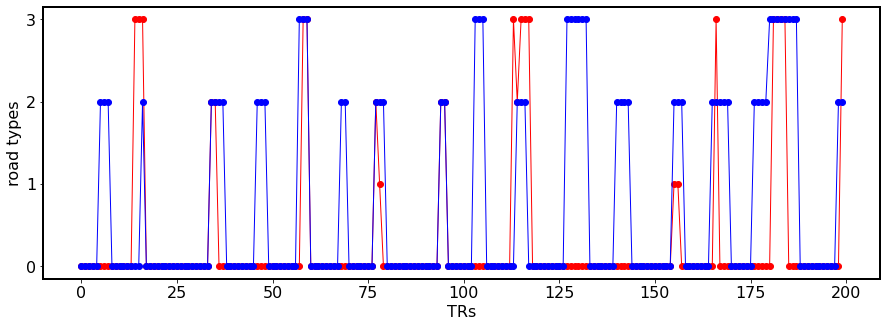

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(regions_train, road_labels_classes_train)

road_labels_classes_pred = clf.predict(regions_test)
# print(clf.predict_proba(regions_test))
clf_score = clf.score(regions_test, road_labels_classes_test)
print("clf_score:", clf_score)

# vis
fig, ax1 = plt.subplots(figsize=(15, 5))
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

colors = plt.cm.coolwarm(np.linspace(0, 1, 20))

lns1 = ax1.plot(road_labels_classes_pred, 'o-', color='r', linewidth=1)
lns2 = ax1.plot(road_labels_classes_test, 'o-', color='b', linewidth=1)
ax1.set_xlabel('TRs')
ax1.set_ylabel('road types', color='k')
ax1.set_yticks([0, 1, 2, 3]) 
plt.show()
